# Telco Customer Churn

Customer churn is defined as customers that left in the last month, and can be due to several reasons like finding a better deal at a different company. In order to reduce churn and retain as many customers as possible, companies must predict which customers are likely to leave and increase their satisfaction with the product. By using customer information like demographics, deal type, and history, we can create a model to learn patterns in customer churn.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import xgboost as xgb

Below is a subset of customer data containing information about 7,043 different customers. The data also has 21 columns describing different aspects of the customer and what services they are paying for.

The data comes from the Kaggle dataset here https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [2]:
churn_raw = pd.read_csv('churn.csv')
churn_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Cleaning

First we can see all of the different features in the dataset. There are no empty values in the data at first glance. Most of the values are Strings of 'Yes' and 'No' values with senior citize, tenure, and monthly charges as numerical data. For consistency the total charges should also be numerical while senior citizen can be converted to a string type. 

In [3]:
churn_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


An issue with the total charges column is that some of the values show up as empty strings. This is because some users are on their first month and haven't made any payments yet, so there is no record of total payments. We can fix this by filling these values with 0 to convert it to a number.

In [4]:
churn = churn_raw.drop(columns=['customerID'])
churn = churn.rename(columns={'gender': 'Gender', 'tenure': 'Tenure'})
churn[churn['TotalCharges'] == ' '].head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No


In [5]:
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce').astype(float)
churn['TotalCharges'] = churn['TotalCharges'].fillna(0)

churn["SeniorCitizen"] = churn["SeniorCitizen"].map({0: "No", 1: "Yes", 'No': 'No', 'Yes': 'Yes'})
churn["PaymentMethod"] = churn["PaymentMethod"].map({
    'Bank transfer (automatic)': 'Bank transfer', 
    'Bank transfer': 'Bank transfer',
    'Credit card (automatic)': 'Credit card',
    'Credit card': 'Credit card',
    'Electronic check': 'Electronic check',
    'Mailed check': 'Mailed check'
})
churn.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


After cleaning up the dataset, all of the columns now have the right data type and no empty values.

In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


# Exploratory Data Analysis

We can compare customer churn to the other features in the dataset to see if we can find any relationships between them. This can help future predictions if we find features that are highly correlated with customer churn.

In [7]:
def plot_bar_chart(feature):
    """
    Plots a grouped bar chart of the given feature against the customer churn.

    Parameters:
    feature (str): The feature to plot
    """
    grouped = churn.groupby([feature, 'Churn']).size().unstack(fill_value=0)
    frequencies = grouped.div(grouped.sum(axis=1), axis=0)

    x = np.arange(len(frequencies))
    n_subgroups = len(frequencies.columns)
    width = 0.8 / n_subgroups 

    fig, ax = plt.subplots()

    for i, subgroup in enumerate(frequencies.columns):
        offset = (i - n_subgroups / 2) * width + width / 2
        ax.bar(x + offset, frequencies[subgroup], width, label=subgroup)

    ax.set_xticks(x)
    ax.set_xticklabels(grouped.index)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Churn by {feature}')
    ax.legend(title='Churn')

    plt.tight_layout()
    plt.show()

def plot_box_plot(feature):
    """
    Plots a grouped box plot of the given feature against the customer churn.

    Parameters:
    feature (str): The feature to plot
    """
    grouped_data = [churn[churn['Churn'] == group][feature].values for group in churn['Churn'].unique()]

    fig, ax = plt.subplots()
    ax.boxplot(grouped_data, labels=churn['Churn'].unique())

    ax.set_xlabel('Churn')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} by Churn')

    plt.show()

### Churn

26.5% of customers left the company last month while 73.5% of customers stayed. Improving the model for predicting churn is very useful because retaining a quarter of customers can make a lot of money for the company. However it may cause a problem for predictions because of the imbalance. The model should make sure not to weight too heavily towards predicting 'No' because it is the larger class.

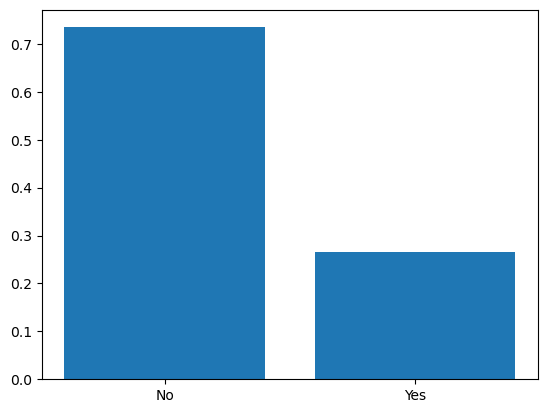

In [8]:
data = churn['Churn'].value_counts(normalize=True)
plt.bar(data.index, data.values)
plt.show()

### Gender

Contains the gender of the customer. It seems to not have a significant effect on the churn rate.

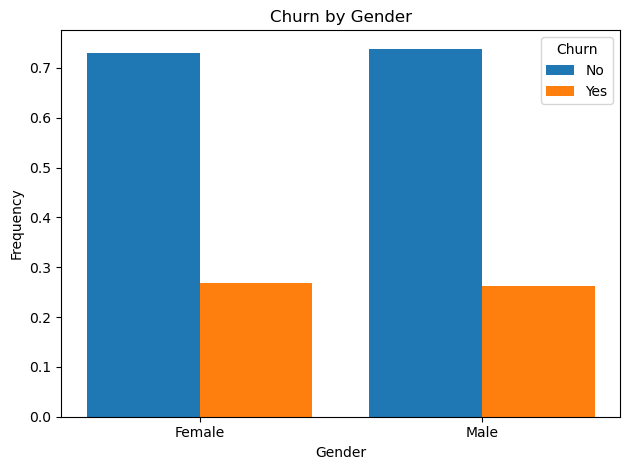

In [9]:
plot_bar_chart('Gender')

### Senior Citizen

Senior citizens seem like they are more likely to leave compared to younger citizens. This could be for a number of reasons like they are going to live with family and no longer need their own phone line.

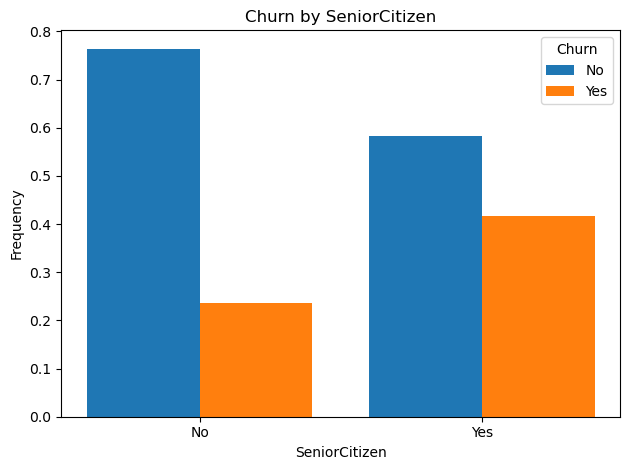

In [10]:
plot_bar_chart('SeniorCitizen')

### Partner

People without partners are more likely to churn which could be because they are free to make the decision on their own without thinking about how it would affect another person's service.

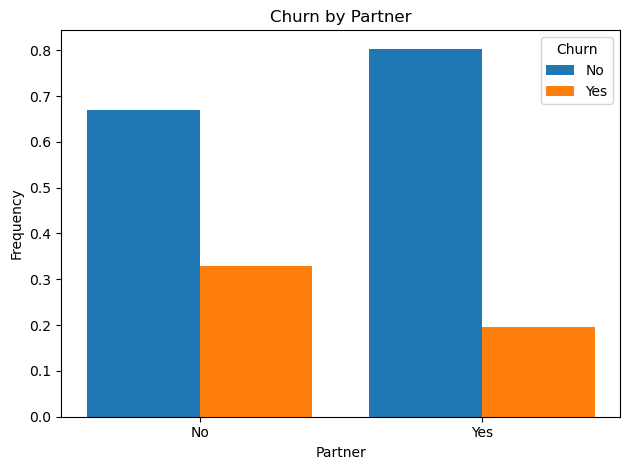

In [11]:
plot_bar_chart('Partner')

### Dependents

For the same reason as the people who have partners, people without dependents are more likely to churn.

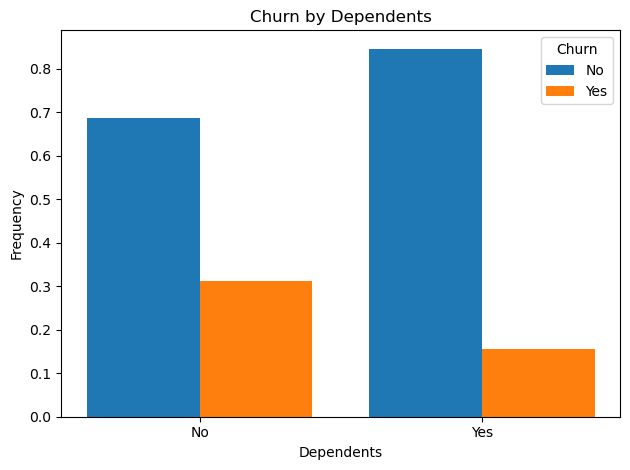

In [12]:
plot_bar_chart('Dependents')

### Phone Service

About the same proportion of people who have the phone service or do not churn.

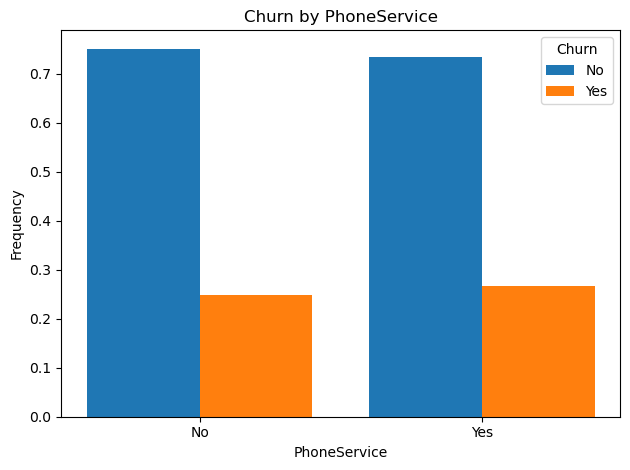

In [13]:
plot_bar_chart('PhoneService')

### Multiple Lines

It seems like having multiple lines does not have much of an impact on customer churn

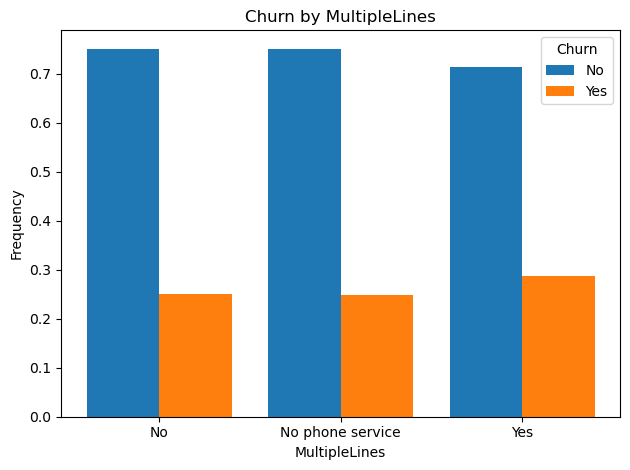

In [14]:
plot_bar_chart('MultipleLines')

### Internet Service

Customers with fiber optic are very likely to churn compared to the other options. This might be due to lower quality of fiber optic compared to other companies and could be an area to look further into.

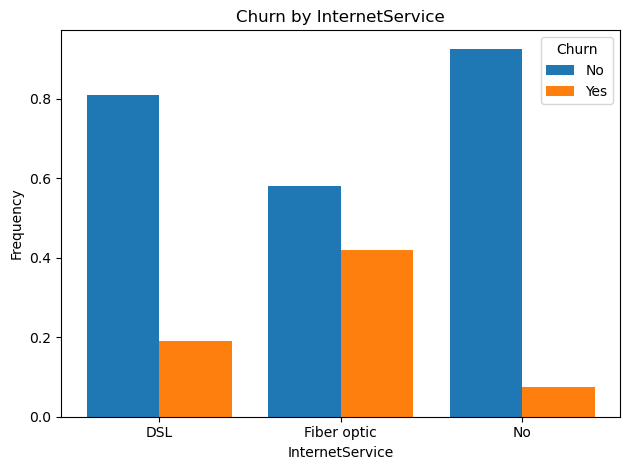

In [15]:
plot_bar_chart('InternetService')

### Online Security

Customers without any security are far more likely to churn, likely because it is a feature they want to feel safer and want to get it an another company.

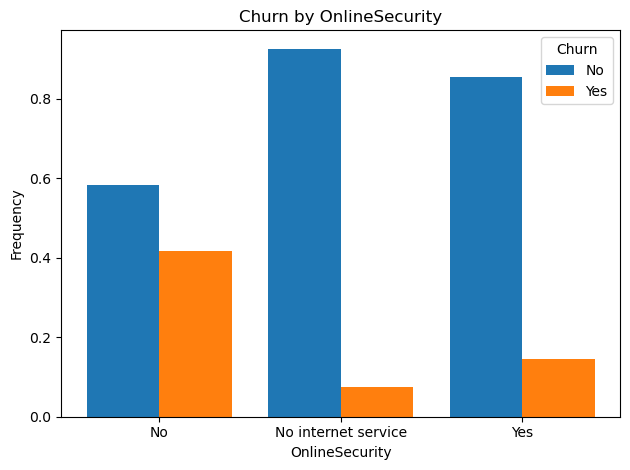

In [16]:
plot_bar_chart('OnlineSecurity')

### Online Backup

Like with the security feature, customers who don't have a backup option are more likely to churn because they want access to this feature.

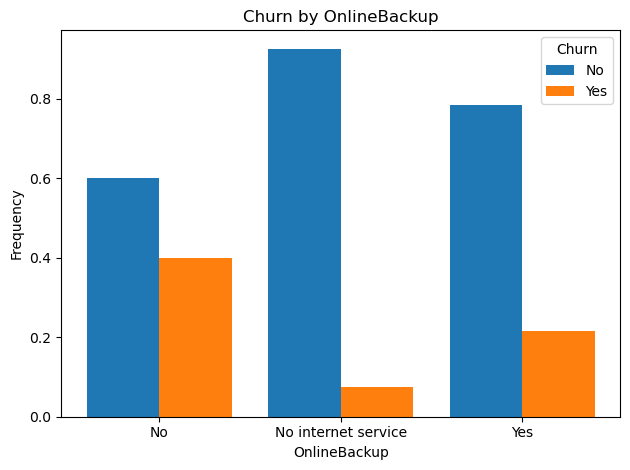

In [17]:
plot_bar_chart('OnlineBackup')

### Device Protection

Like the other features, customers are more likely to churn if they don't have device protection.

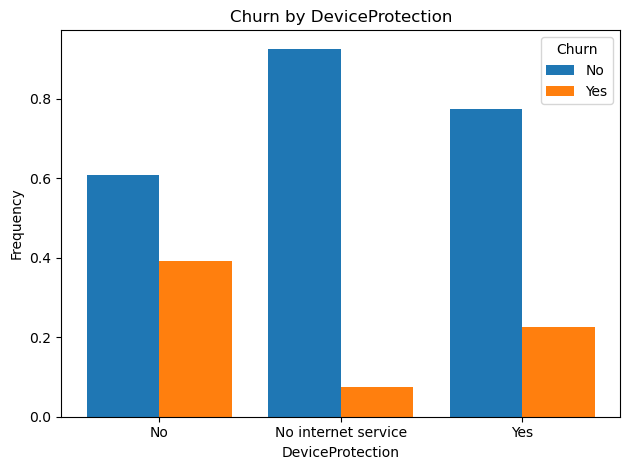

In [18]:
plot_bar_chart('DeviceProtection')

### Tech Support

Like the other features, customers are more likely to churn if they don't have tech support.

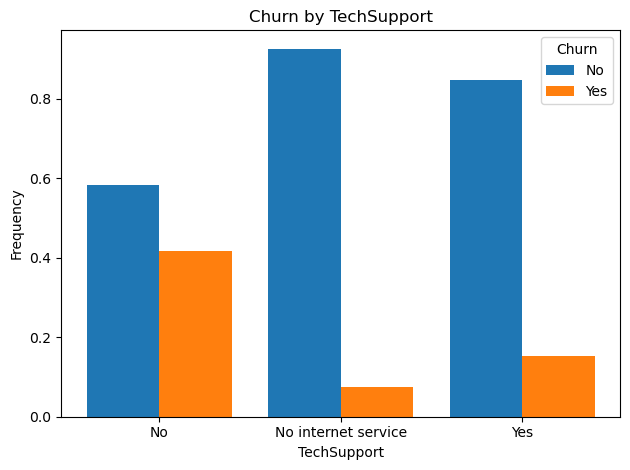

In [19]:
plot_bar_chart('TechSupport')

### TV Streaming

TV Streaming seems to be less of a factor for churn for customers who do not have any internet service.

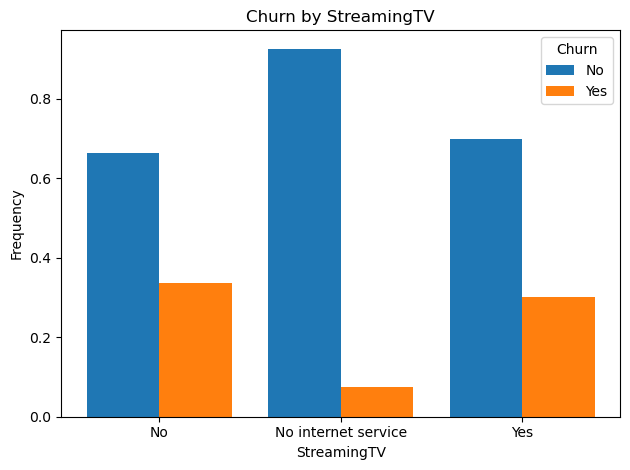

In [20]:
plot_bar_chart('StreamingTV')

### Movie Streaming

Like TV streaming, movie streaming seems to be less of a factor for churn for customers who do not have any internet service.

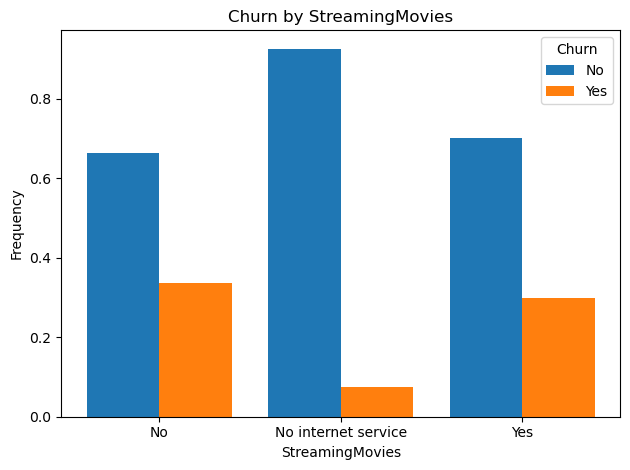

In [21]:
plot_bar_chart('StreamingMovies')

### Contract

Customers on a monthly contract are far more likely to churn than ones on yearly contracts. This is likely because it is hard to leave in the middle of a contract due to fees or other penalties.

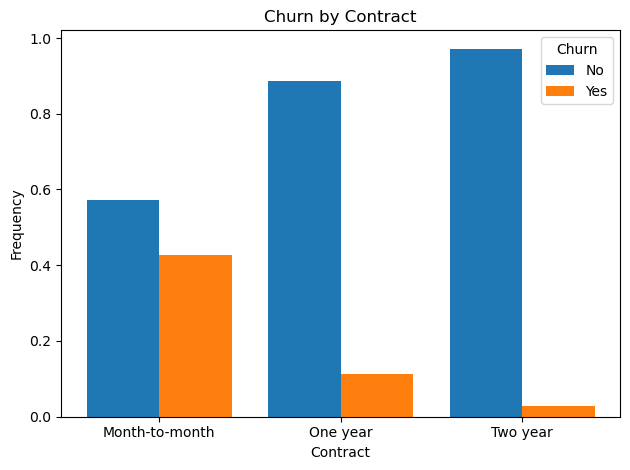

In [22]:
plot_bar_chart('Contract')

### Paperless Billing

Customers who use digital methods of paying churn more. This could be because it is easier to cancel online on a website rather than having to go into a physical store or call someone which is more likely with paper billing.

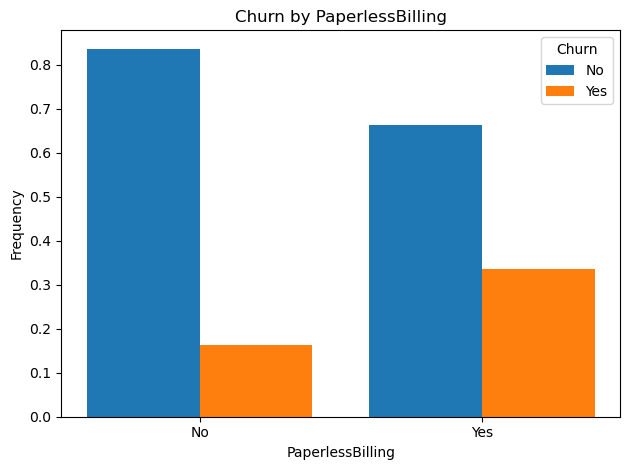

In [23]:
plot_bar_chart('PaperlessBilling')

### Payment Method

Customers who paid with electronic checks were more likely to churn than any other method. It would be useful for the company to keep track of people who pay with checks to make sure they are not close to leaving.

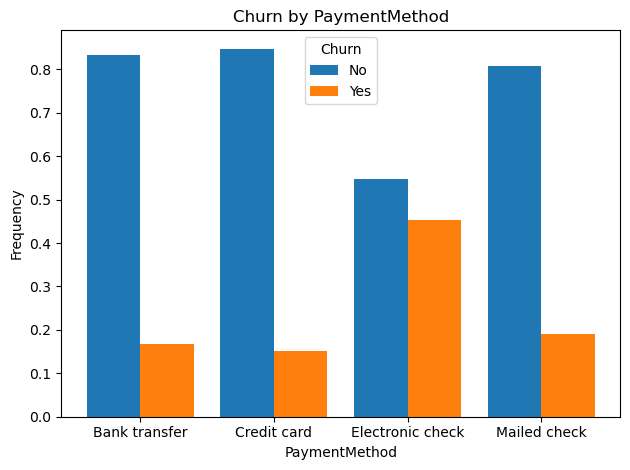

In [24]:
plot_bar_chart('PaymentMethod')

### Tenure

Newer customers are more likely to churn, because those who have been with the company for a long time are likely happy with the service.

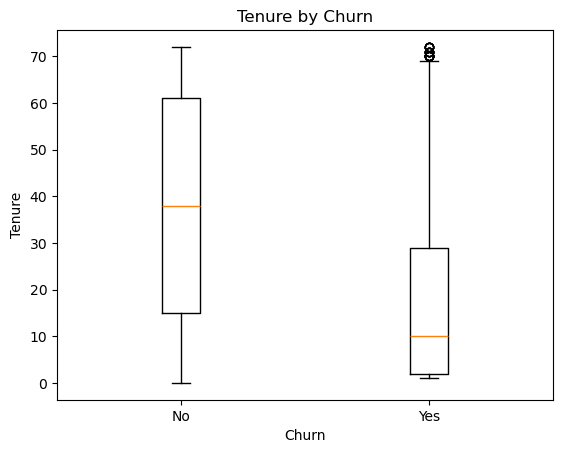

In [25]:
plot_box_plot('Tenure')

### Monthly Charges

Customers with a high monthly bill are more likely to churn. They might have found a better deal with another company that let them spend less.

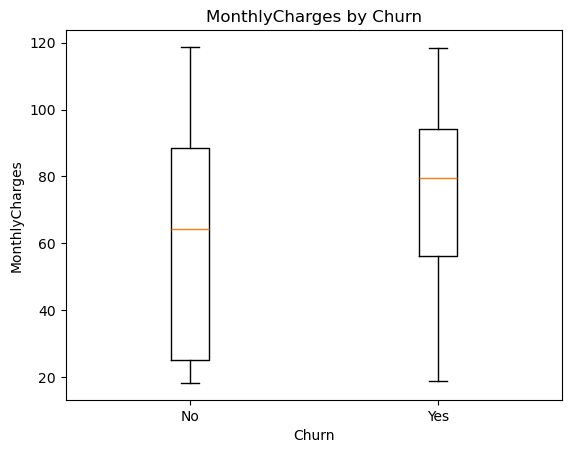

In [26]:
plot_box_plot('MonthlyCharges')

### Total Charges

Total charges are correlated with the time spent with the company, and shows that newer customers are more likely to churn.

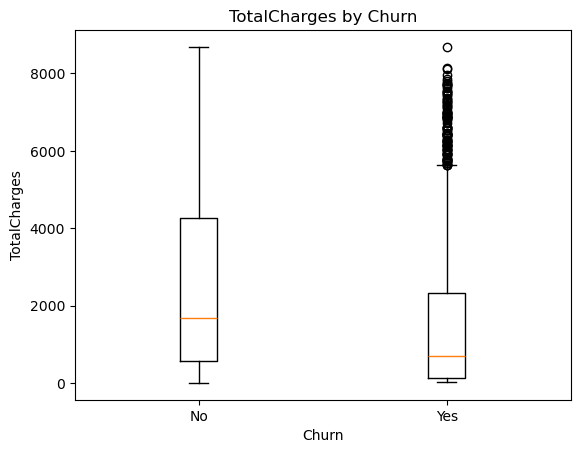

In [27]:
plot_box_plot('TotalCharges')

# Correlation Analysis

From the univariate analysis it seems like a lot of the features are correlated with each other. We can create a heatmap to see which features are closely related to see some more patterns in the data.

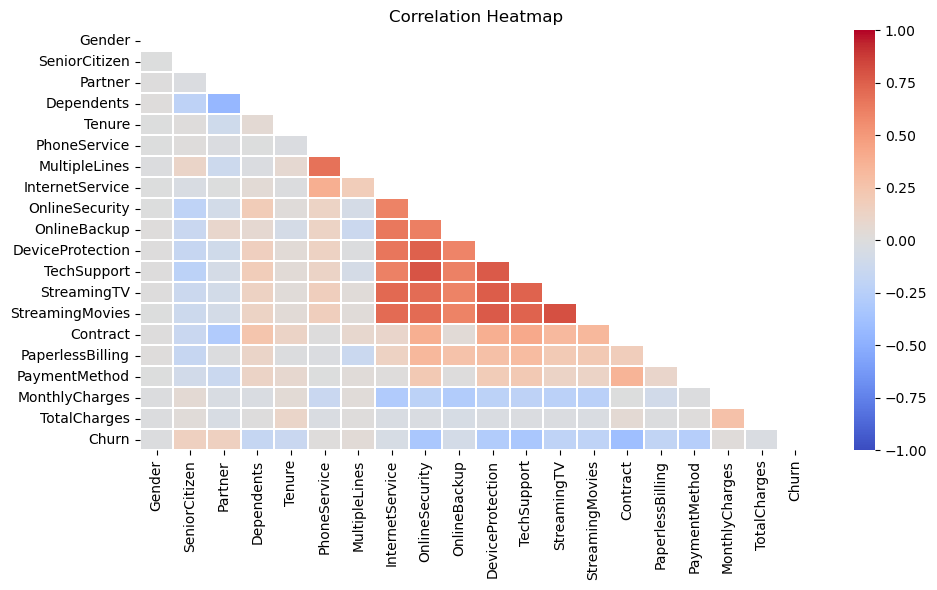

In [28]:
corr = churn.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    mask=mask,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=0.2,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

We can look at the absolute values of the correlations to see the strength of relationships between features. Some important relationships include:

1. There is a high correlation between internet service, online security, online backup, device protection, tech support, streaming TV, and streaming movies. These are all very similar types of features and someone who gets one of them is likely to get multiple of them.
2. There is a strong relationship between having partners and dependents, since they are likely buying a plan for their whole family.
3. Churn is very correlated with online security, tech support, and contract type. It should be highly correlated with tenure as shown above but it doesn't show here due to the difference in data types.

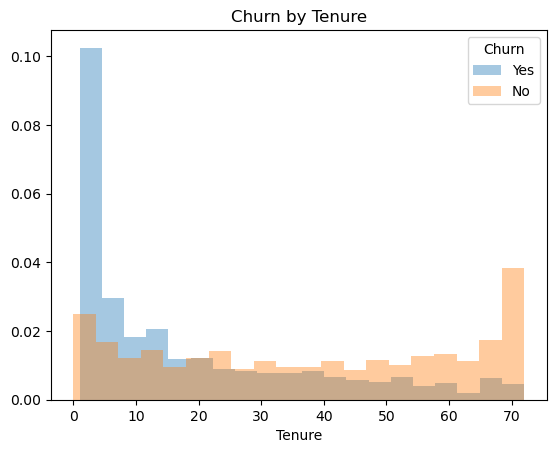

In [32]:
tenure_yes = churn[churn['Churn'] == 'Yes']['Tenure']
tenure_no = churn[churn['Churn'] == 'No']['Tenure']

plt.hist(tenure_yes, density=True, bins=20, alpha=0.4, label='Yes')
plt.hist(tenure_no, density=True, bins=20, alpha=0.4, label='No')
plt.legend(title='Churn')
plt.title('Churn by Tenure')
plt.xlabel('Tenure')
plt.show()

# Data Preprocessing

Since most of the features are categorical, first we one hot encode them to get them into numerical form. We keep a feature for each different value that each different feature could have. We also standardize the numerical features of tenure, monthly charges, and total charges. This is so that they don't have too big an effect compared to the other features.

In [34]:
features = pd.get_dummies(churn, drop_first=True)
for col in ['Tenure', 'MonthlyCharges', 'TotalCharges']:
    features[col] = (features[col] - np.mean(features[col])) / np.std(features[col])
    
features.head()

,Tenure,MonthlyCharges,TotalCharges,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,-1.277445,-1.160323,-0.992611,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0.066327,-0.259629,-0.172165,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,-1.236724,-0.362660,-0.958066,True,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0.514251,-0.746535,-0.193672,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,-1.236724,0.197365,-0.938874,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True


Then we split the data into training and testing sets to create the model.

In [41]:
X = features[features.columns[:-1]]
y = features['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Model Training

### Logistic Regression

Training logistic regression on 5 folds of validation with a range of regularizers from 10^-4 to 10^4

In [43]:
clf = LogisticRegressionCV(cv=5, Cs=10)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      1024
        True       0.69      0.55      0.61       385

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



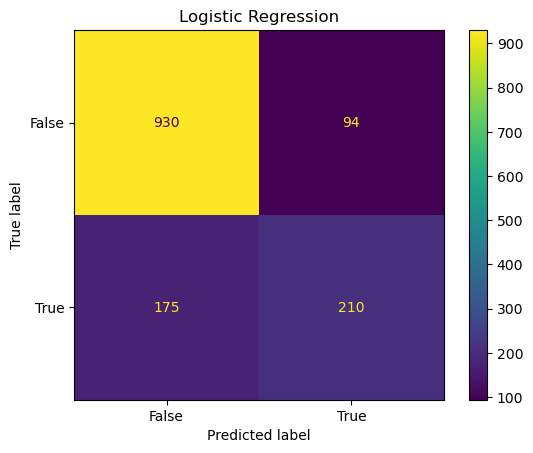

In [83]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.title('Logistic Regression')
plt.show()

### K Nearest Neighbors

Training K nearest neighbors of 5 folds of cross validation with different amounts of neighbors to compare

In [61]:
param_grid = {
    'n_neighbors': [5, 15, 25, 35, 45]
}
cv = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=20, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=20,
             param_grid={'n_neighbors': [5, 15, 25, 35, 45]})

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      1024
        True       0.69      0.55      0.61       385

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



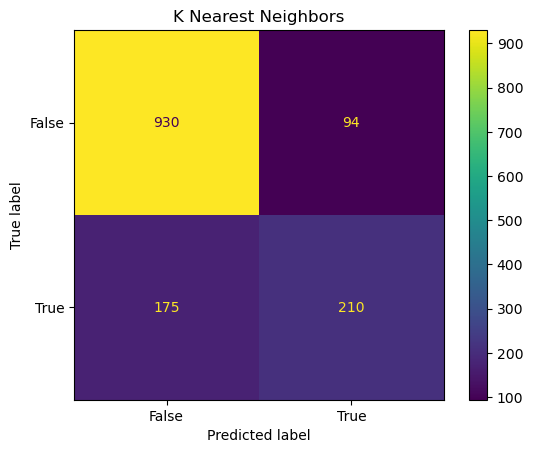

In [84]:
clf = cv.best_estimator_
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.title('K Nearest Neighbors')
plt.show()

### Support Vector Classifier

Training SVC over 5 fold cross validation with different regularization parameters

In [64]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
cv = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=20, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=20,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      1024
        True       0.69      0.55      0.61       385

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



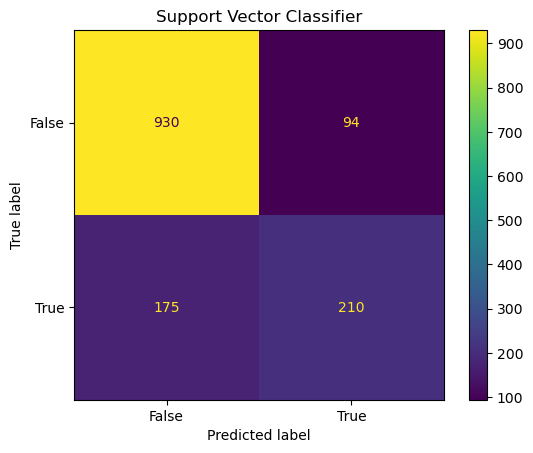

In [85]:
clf = cv.best_estimator_
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.title('Support Vector Classifier')
plt.show()

### Random Forest

Training a random forest over 5 folds on number of trees and max depth of trees

In [79]:
param_grid = {
    'n_estimators': [51, 101, 151, 201, 251],
    'max_depth': [5, 10, 15, 20, 25]
}
cv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=20, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=20,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [51, 101, 151, 201, 251]})

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      1024
        True       0.69      0.55      0.61       385

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



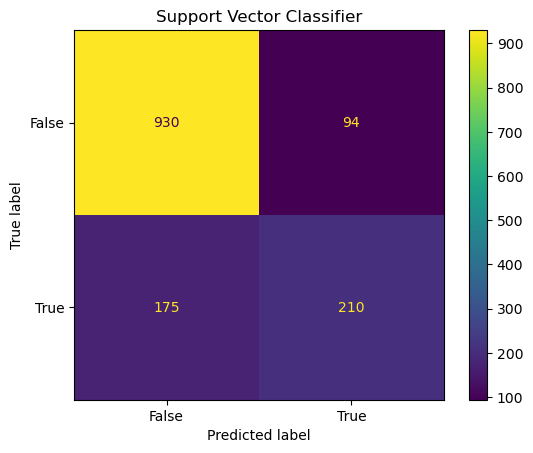

In [86]:
clf = cv.best_estimator_
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.title('Support Vector Classifier')
plt.show()

### Results

| Model                     | Precision | Recall | F1-score |
|---------------------------|-----------|--------|----------|
| Logistic Regression       | 0.80      | 0.81   | 0.80     |
| K Nearest Neighbors       | 0.79      | 0.80   | 0.80     |
| Support Vector Classifier | 0.79      | 0.80   | 0.79     |
| Random Forest             | 0.80      | 0.81   | 0.80     |

All of the models have very similar results with F1 scores around 0.8

# Model Explanation

Using SHAP analysis we can see which features are most important to the prediction. SHAP assigns credit to different features in the model in order to explain why it gives the output that it does.

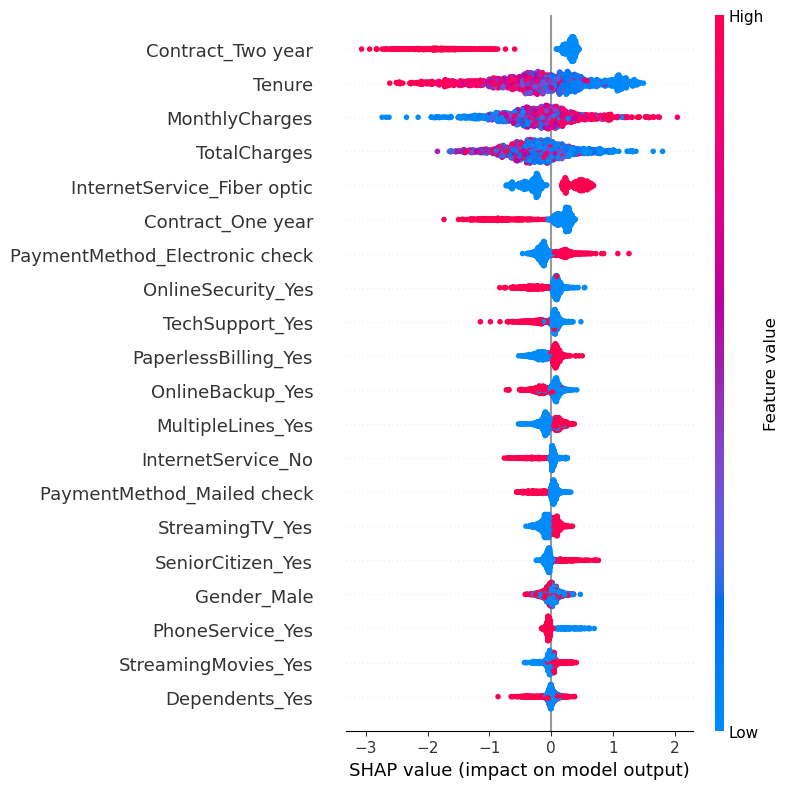

In [114]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.initjs()

shap.summary_plot(shap_values, X_test, plot_size=(8, 8))

The features are listed in order of most to least important so we can see that the the two year contracts are the most important factor in a customer leaving. The red dots represents two year contracts and blue ones represent lower lengths, showing that the long contracts mean customers aren't leaving. The next few important features like tenure, monthly charges, total charges, and fiber optic are consistent from the previous analysis showing that they are very correlated with churn. Long tenure leads to a low chance to churn while high charges lead to a higher chance to churn.

In [154]:
preds = clf.predict(X_test)
errors = [i for i, x in enumerate((preds != y_test)) if x]

We can look at some examples of failed predictions to see why the model failed. In this first example the customer did not churn and the model predicted that they would. Their short tenure, fiber optic, and two year contract all contributed to this decision because these are more correlated with customers that churn. The contributions from features that push it towards not predicting churn like credit card payments were not enough and it predicted wrong.

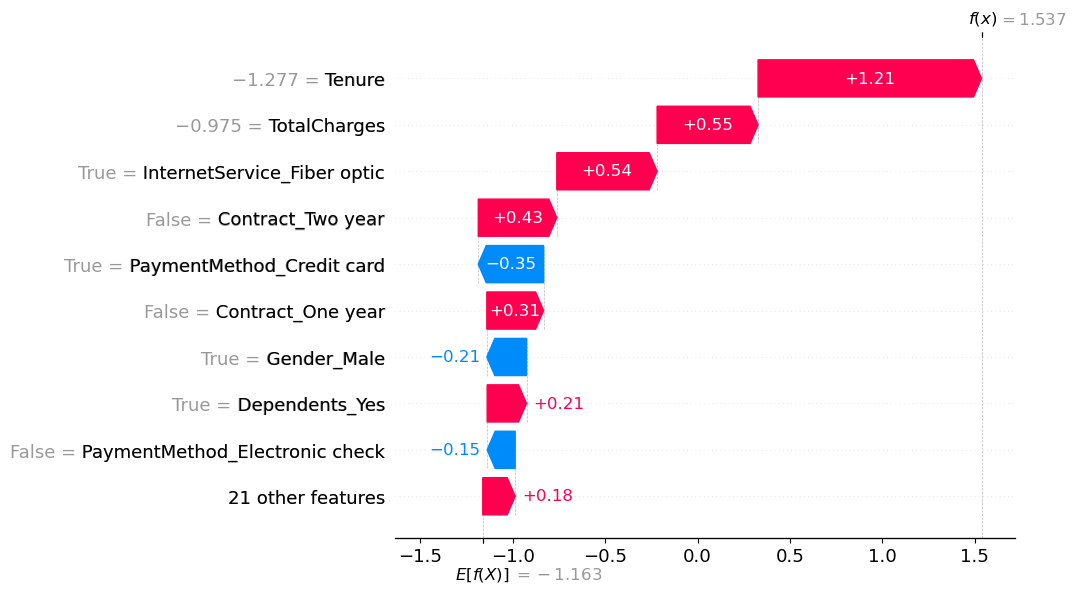

In [162]:
shap.waterfall_plot(shap_values[errors[0]])

In this case below the customer left but the model predicted they would not. The customer had a very long tenure and one year contract which usually meant that the user would not churn. However the effects of their large monthly bill and electronic check payments could not offset this and the model was wrong. This type of error is worse because the company lost a customer that they otherwise could have kept if they knew in advance. In contrast the other error where the company falsely thought the customer was leaving was less bad because they kept the customer still.

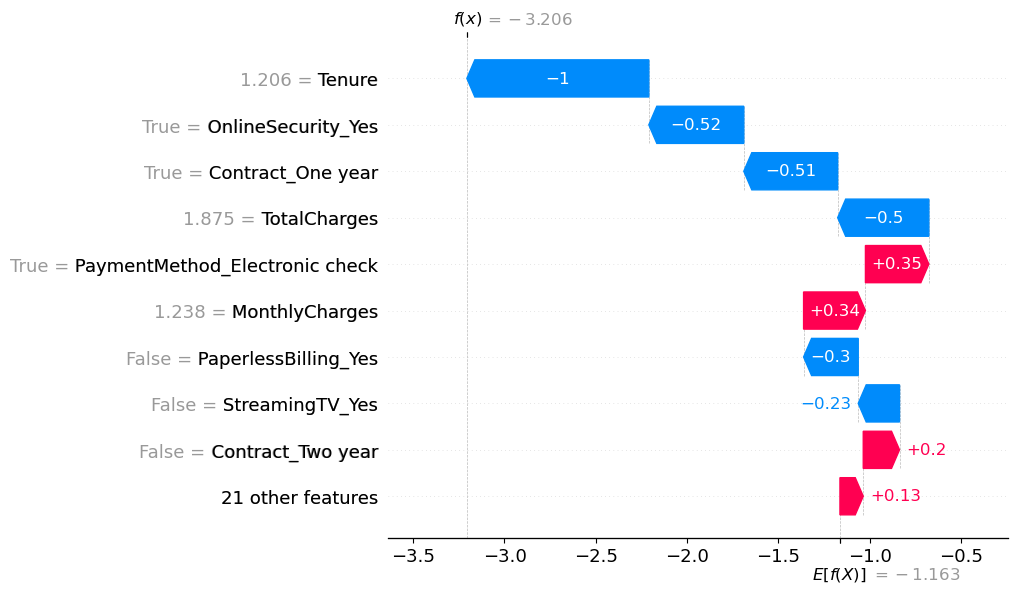

In [148]:
shap.waterfall_plot(shap_values[errors[1]])

# Conclusion

Overall the model predicts customer churn correctly about 80% of the time. For the times that it is wrong, it is more useful to focus on false negative where they didn't realize a customer was leaving. In order to lower churn, some features to look at are getting more 2 year contracts and lowering the monthly bill. In addition, the company should fix their fiber optic service because it seems to drive customers away. By improving the services the company can build some more brand loyalty, since one of the most important reasons that customers don't leave is that they have been with the company for a long time already.